# Vision Transformer Test

Motivated by [NASA and IBM's Prithvi](https://arxiv.org/abs/2412.02732), we seek to construct a [Vision Transformer](https://arxiv.org/abs/2010.11929)-based spatio-temporal [Masked Autoencoder](https://arxiv.org/pdf/2111.06377), and to test the principle using a downsampled version of the [Moving MNIST dataset](https://www.cs.toronto.edu/~nitish/unsupervised_video/).

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys
import torch
from tqdm.notebook import tqdm

from torch.utils.data import DataLoader, default_collate, RandomSampler
from torchvision import datasets, transforms
sys.path.insert(0, '..')

## Spatial Masked Autoencoder

We first examine the 2D masked autoencoder implemented by Facebook Research at https://github.com/facebookresearch/mae/tree/main and licenced under CC-BY-NC 4.0. We implement the `MaskedAutoencoderViT` class and train using the MNIST dataset, of greyscale images of handwritten numerals.

In [2]:
from src.FRAME_FM.models.mae_2d.models_mae import MaskedAutoencoderViT

accelerator = torch.accelerator.current_accelerator()
device = "cpu" if accelerator is None else accelerator.type
model = MaskedAutoencoderViT(
    img_size=28,  # Size of input image (height and width, in pixels)
    patch_size=4,  # Size of patches over which attention operates
    in_chans=1,  # Number of channels of input image
    embed_dim=8,  # Number of dimensions into which input is embedded
    depth=4,  # Number of attention layers for encoding
    num_heads=4,  # Number of attention heads in each layer
    decoder_embed_dim=8,  # Number of dimensions into which output is embedded
    decoder_num_heads=4,  # Number of attention heads for decoding
    mlp_ratio=4.,  # Ratio between dimensions of MLP layer and of embedding
    norm_layer=torch.nn.LayerNorm,  # Class of normalisation layer
    norm_pix_loss=False,  # Whether to normalise target pixels in loss calculation
    ).to(device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.05, lr=1e-4, betas=(0.9, 0.95))

def construct_mnist_dataloader(directory, train=True):
    dataset = datasets.MNIST(
        directory,
        train=train,
        download=True,
        transform=transforms.ToTensor(),
        )
    dataloader = DataLoader(
        dataset, batch_size=64, shuffle=train, drop_last=True,
        collate_fn=lambda batch: default_collate(batch)[0])
    return dataloader

project_directory = Path(r"C:\Users\matarran\OneDrive - NERC\Documents\Projects\FRAME-FM")
dataloader_train = construct_mnist_dataloader(project_directory, train=True)
dataloader_test = construct_mnist_dataloader(project_directory, train=False)
mask_ratio = 0.5
state_path = project_directory / r"FRAME-FM\configs\experiment\best_MNIST_MAE.pth"
load_state_path = True
epochs = 1

def train_one_epoch(dataloader, model, device, mask_ratio, optimizer):
    model.train()
    for batch in (batch_progress := tqdm(dataloader, desc="Training progress", leave=False)):
        batch = batch.to(device, non_blocking=True)
        loss, _, _ = model(batch, mask_ratio=mask_ratio)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_progress.set_postfix_str(f"Batch loss: {loss.item(): g}")

def test(dataloader, model, device, mask_ratio):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Test progress", leave=False):
            batch = batch.to(device)
            loss, _, _ = model(batch, mask_ratio=mask_ratio)
            test_loss += loss.item()
    return test_loss / len(dataloader)

def train_model(dataloader_train, dataloader_test, mask_ratio, model, device, optimizer, epochs):
    best_loss = test(dataloader_test, model, device, mask_ratio)
    for _ in (epoch_progress := tqdm(range(epochs))):
        train_one_epoch(dataloader_train, model, device, mask_ratio, optimizer)
        test_loss = test(dataloader_test, model, device, mask_ratio)
        epoch_progress.set_postfix_str(f"Test loss {test_loss:g}, cf. previous best {best_loss:g}")
        if test_loss < best_loss:
            torch.save(model.state_dict(), state_path)
            best_loss = test_loss

if load_state_path and state_path.is_file():
    model.load_state_dict(torch.load(state_path, weights_only=True))
train_model(dataloader_train, dataloader_test, mask_ratio, model, device, optimizer, epochs)

Test progress:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training progress:   0%|          | 0/937 [00:00<?, ?it/s]

Test progress:   0%|          | 0/156 [00:00<?, ?it/s]

Performance is fairly poor, but clearly better than random chance:

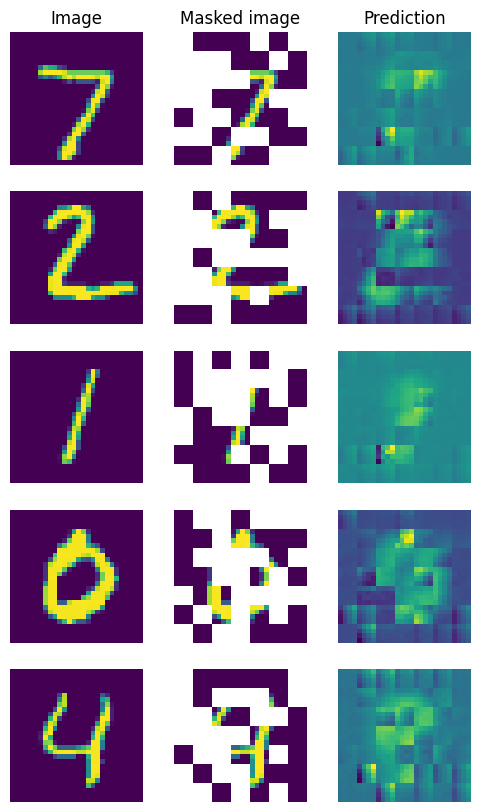

In [3]:
batch = next(iter(dataloader_test))
with torch.no_grad():
    _, pred, mask = model(batch, mask_ratio=mask_ratio)
    masked_patches = torch.where(torch.unsqueeze(mask, -1) == 0, model.patchify(batch), np.nan)
    masked_batch = model.unpatchify(masked_patches)
    pred_batch = model.unpatchify(pred)

fig, axs = plt.subplots(5, 3, figsize=[6, 10])
axs[0, 0].set_title("Image")
axs[0, 1].set_title("Masked image")
axs[0, 2].set_title("Prediction")
for ax_row, img, masked_img, pred_img in zip(axs, batch, masked_batch, pred_batch):
    ax_row[0].imshow(img[0])
    ax_row[0].set_axis_off()
    ax_row[1].imshow(masked_img[0])
    ax_row[1].set_axis_off()
    ax_row[2].imshow(pred_img[0])
    ax_row[2].set_axis_off()

## Spatiotemporal Masked Autoencoder

In [4]:
from src.FRAME_FM.models.mae_st.models_mae import MaskedAutoencoderND

model = MaskedAutoencoderND(
    input_shape=(20, 64, 64),  # Shape of input (in pixels)
    patch_shape=(4, 4, 4),  # Shape of patches over which attention operates
    input_channels=1,  # Number of channels of input image
    embed_dim=8,  # Number of dimensions into which input is embedded
    depth=4,  # Number of attention layers for encoding
    num_heads=4,  # Number of attention heads in each layer
    decoder_embed_dim=8,  # Number of dimensions into which output is embedded
    decoder_num_heads=4,  # Number of attention heads for decoding
    mlp_ratio=4.,  # Ratio between dimensions of MLP layer and of embedding
    norm_layer=torch.nn.LayerNorm,  # Class of normalisation layer
    norm_pix_loss=False,  # Whether to normalise target pixels in loss calculation
    ).to(device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.05, lr=1e-4, betas=(0.9, 0.95))

def construct_moving_mnist_dataloader(directory, train=True):
    dataset = datasets.MovingMNIST(directory, download=True)
    dataloader = DataLoader(
        dataset,
        sampler=RandomSampler(range(900)) if train else range(900, 1000),
        batch_size=4,
        drop_last=True,
        collate_fn=lambda batch: default_collate(batch).transpose(1, 2) / 8,
        )
    return dataloader

dataloader_train = construct_moving_mnist_dataloader(project_directory, train=True)
dataloader_test = construct_moving_mnist_dataloader(project_directory, train=False)
mask_ratio = 0.5
state_path = project_directory / r"FRAME-FM\configs\experiment\best_Moving_MNIST_MAE.pth"
load_state_path = False
epochs = 1

if load_state_path and state_path.is_file():
    model.load_state_dict(torch.load(state_path, weights_only=True))
train_model(dataloader_train, dataloader_test, mask_ratio, model, device, optimizer, epochs)

Test progress:   0%|          | 0/25 [00:01<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training progress:   0%|          | 0/225 [00:00<?, ?it/s]

Test progress:   0%|          | 0/25 [00:00<?, ?it/s]

Results:

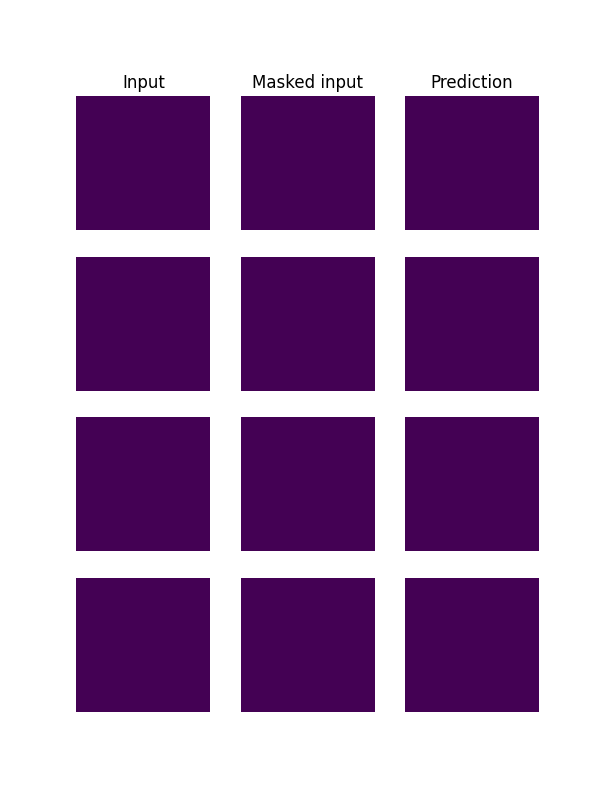

In [45]:
%matplotlib widget

batch = next(iter(dataloader_test))
with torch.no_grad():
    _, pred, mask = model(batch, mask_ratio=mask_ratio)
    masked_patches = torch.where(
        torch.unsqueeze(mask, -1) == 0, model.patch_embed.patchify(batch), np.nan
        )
    masked_batch = model.patch_embed.unpatchify(masked_patches)
    pred_batch = model.patch_embed.unpatchify(pred)

fig, axs = plt.subplots(4, 3, figsize=[6, 8])
axs[0, 0].set_title("Input")
axs[0, 1].set_title("Masked input")
axs[0, 2].set_title("Prediction")
plt_imgs = []
for ax_row in axs:
    plt_imgs.append([ax.imshow(np.zeros([64, 64]), vmin=0, vmax=1) for ax in ax_row])
    for ax in ax_row:
        ax.set_axis_off()

def animate(frame):
    for plt_row, img, masked_img, pred_img in zip(
        plt_imgs, batch[:, 0, frame], masked_batch[:, 0, frame], pred_batch[:, 0, frame]
        ):
        plt_row[0].set_array(img)
        plt_row[1].set_array(masked_img)
        plt_row[2].set_array(pred_img)
    return (plt_img for plt_row in plt_imgs for plt_img in plt_row)

animation = FuncAnimation(fig, animate, frames=20)